## Imports

In [2]:
import scipy.linalg as sci
import numpy as np
import requests
import xml.etree.ElementTree as ET
import csv
import pandas as pd
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import math
import time

In [3]:
def fetch_page(url):
    response = requests.get(url)
    # 200 is a success code
    if response.status_code == 200:
        return response.content
    else:
        print("Failed to fetch page:", url)
        return None
    

# Function to parse XML data and extract member information
def parse_senate(xml_data):
    members_data = []
    root = ET.fromstring(xml_data)
    members = root.findall('.//members/member')
    for member in members:
        member_data = {
            'name': member.find('member_full').text,
            'vote': member.find('vote_cast').text
        }
        members_data.append(member_data)
    return members_data

def normalize_data(U):

    # Normalize x and y each between -1 and 1
    U_min = U.min(axis=0)
    U_max = U.max(axis=0)
    U_range = U_max - U_min

    U[:, 0] = 2 * (U[:, 0] - U_min[0]) / U_range[0] - 1  # Normalize x
    U[:, 1] = 2 * (U[:, 1] - U_min[1]) / U_range[1] - 1 
    return U


# Senate Scraper

In [5]:
senate_df = pd.DataFrame(columns=['Session','Senate','S_R_error','S_D_error'])

In [13]:
# Presidential control: 1 = R, -1 = D
# House/Senate Margin: R-D (More Rs = positive, more Ds = negative)

senate_df = pd.DataFrame(columns=['Session','Senate','S_R_error','S_D_error'])

base_url_senate = "https://www.senate.gov/legislative/LIS/roll_call_votes/vote1011/vote_101_1"

congress_list = np.arange(118,118.5,0.5)

for l in congress_list:
    congress = int(l)
    if l%1 == .5:
        session = 2
    else:
        session = 1

    print(f'Beginning scrape of Congress {congress}, Session {session}')
    
    c_url = f"https://www.senate.gov/legislative/LIS/roll_call_votes/vote{congress}{session}/vote_{congress}_{session}"

    url_build_1 = c_url

    xml_data_list = []

    i = 1
    while True:
        url = url_build_1 + '_{}.xml'.format("{:05d}".format(i))  # Construct URL with current number
        xml_data = fetch_page(url)

        # Response Validation
        if not xml_data: break

        print(f'found page {i} ({congress}, {session})')
        soup = bs(xml_data,'xml')
        if soup.find('title'):
            break

        if xml_data:
            data=parse_senate(xml_data)
            xml_data_list.append(data)  # Append XML data to the list
        
        time.sleep(1)
        i+=1

    # Render the xml list into a Dataframe.

    dict={'Yea':1,'Nay':-1,'Not Voting':0,'Guilty':1,'Not Guilty':-1}

    df=pd.DataFrame(xml_data_list[0]).drop(columns='vote',axis=1) # Create the first column of the dataframe

    # Assemble the vote data
    vote_data = []
    for i in range(len(xml_data_list)):
        column_name = f"vote_{i}"
        temp_d = pd.DataFrame(xml_data_list[i])
        vote_list = temp_d['vote'].map(dict)  
        # Append the vote list as a Series to vote_data
        vote_data.append(vote_list.rename(column_name))
    # Concatenate all the vote data into a single DataFrame
    vote_df = pd.concat(vote_data, axis=1)
    df = pd.concat([df, vote_df], axis=1)
    df = df.fillna(0)
    
    print(f'Votes assembled. {len(df)} Senators, {len(df.columns)-1} votes')

    # Use SVD
    M1=df.drop(columns=['name'],axis=1).to_numpy()
    U,s,Vt=sci.svd(M1)

    U_first_two = pd.DataFrame(normalize_data(U[:, :2]))  

    U_first_two=pd.concat([df['name'].astype(str),U_first_two],axis=1) # Add the names (which are still formatted with party and state)

    # Create the Party and State columns
    U_first_two[['Name','p-s code']] = U_first_two['name'].str.split('(',expand=True)
    U_first_two[['Party','State']] = U_first_two['p-s code'].str.split('-',expand=True)
    U_first_two['Party'] = U_first_two['Party'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
    U_first_two['State'] = U_first_two['State'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

    # Clean up excess columns
    U_first_two = U_first_two.drop(columns=['name','p-s code'],axis=1)
    U_first_two.columns=['0','1','Name','Party','State']

    # Find party center
    S_R=U_first_two[U_first_two['Party']=='R'].drop(['Party','State','Name'],axis=1)
    S_D=U_first_two[U_first_two['Party']=='D'].drop(['Party','State','Name'],axis=1)
    Rcenter = np.mean(S_R,axis=0) # Returns a set of 2 values (xy coords)
    Dcenter = np.mean(S_D,axis=0) # Returns a set of 2 values (xy coords)

    # Calculate party errors (RMSE)
    R_error=[]
    for i in range(0,len(S_R)):
        dist=math.dist(S_R.iloc[i],Rcenter)
        R_error.append(dist**2)
    R_RMSE=np.sqrt(np.mean(R_error))
    print(f'R Error: {R_RMSE}')

    D_error=[]
    for i in range(0,len(S_D)):
        dist=math.dist(S_D.iloc[i],Dcenter)
        D_error.append(dist**2)
    D_RMSE=np.sqrt(np.mean(D_error))
    print(f'D Error: {D_RMSE}')

    senate_df.loc[len(senate_df)] = {'Session':(congress,session),'Senate':len(S_R)-len(S_D),'S_R_error':R_RMSE,'S_D_error':D_RMSE}


Beginning scrape of Congress 118, Session 1
found page 1 (118, 1)
found page 2 (118, 1)
found page 3 (118, 1)
found page 4 (118, 1)
found page 5 (118, 1)
found page 6 (118, 1)
found page 7 (118, 1)
found page 8 (118, 1)
found page 9 (118, 1)
found page 10 (118, 1)
found page 11 (118, 1)
found page 12 (118, 1)
found page 13 (118, 1)
found page 14 (118, 1)
found page 15 (118, 1)
found page 16 (118, 1)
found page 17 (118, 1)
found page 18 (118, 1)
found page 19 (118, 1)
found page 20 (118, 1)
found page 21 (118, 1)
found page 22 (118, 1)
found page 23 (118, 1)
found page 24 (118, 1)
found page 25 (118, 1)
found page 26 (118, 1)
found page 27 (118, 1)
found page 28 (118, 1)
found page 29 (118, 1)
found page 30 (118, 1)
found page 31 (118, 1)
found page 32 (118, 1)
found page 33 (118, 1)
found page 34 (118, 1)
found page 35 (118, 1)
found page 36 (118, 1)
found page 37 (118, 1)
found page 38 (118, 1)
found page 39 (118, 1)
found page 40 (118, 1)
found page 41 (118, 1)
found page 42 (118, 1)

In [10]:
senate_df

,Session,Senate,S_R_error,S_D_error
0,"(118, 1)",1,0.535303,0.273366


In [6]:
senate_df.to_csv('senate_data.csv')

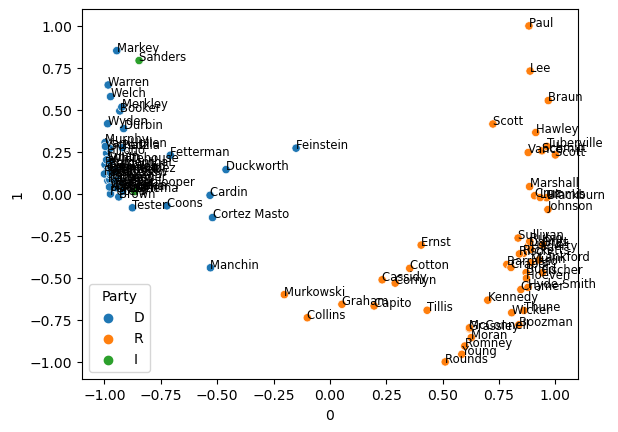

In [15]:
# Plot the senators
p1 = sns.scatterplot(data=U_first_two,x='0',y='1',hue='Party')

for i in range(0,len(U_first_two)):
    p1.text(x=U_first_two['0'].iloc[i], y=U_first_two['1'].iloc[i], 
    s=U_first_two['Name'].iloc[i], horizontalalignment='left', 
    size='small', color='black')
plt.show()